In [44]:
import torch
from torch import nn
from torch import optim
import fastcore.all as fc
from datasets import load_dataset
from torch.utils.data import default_collate, DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from functools import partial

In [3]:
name = 'mnist'
x,y = 'image','label'
dsr = load_dataset(name)

/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Found cached dataset mnist (/Users/arun/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)
100%|██████████| 2/2 [00:00<00:00, 56.53it/s]


In [22]:
def transform(b):
    b[x] = [torch.flatten(TF.to_tensor(ele))*2-1 for ele in b[x]]
    return b

def collate_fn(b):
    clt = default_collate(b)
    return (clt[x], clt[y])

class DataLoaders:
    def __init__(self, train_ds, valid_ds, collate_fn, batch_size):
        self.train = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
        self.valid = DataLoader(valid_ds, batch_size=2*batch_size, collate_fn=collate_fn, shuffle=False)

In [23]:
batch_size = 1024
dst = dsr.with_transform(transform)
dls = DataLoaders(dst['train'], dst['test'], batch_size=batch_size, collate_fn=collate_fn)

In [24]:
xb,yb = next(iter(dls.train))
xb.shape, yb.shape, xb.min(), xb.max()

(torch.Size([1024, 784]), torch.Size([1024]), tensor(-1.), tensor(1.))

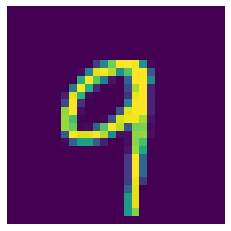

In [25]:
plt.imshow(xb[10].view(28, 28));
plt.axis('off');

In [32]:
class VAE(nn.Module):
    def __init__(self, latent_dim=10):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = self._encoder()
        self.decoder = self._decoder()
    
    def _encoder(self):
        return nn.Sequential(
            nn.Linear(784, 100),
            nn.ReLU(),
            nn.Linear(100, self.latent_dim),
            nn.Tanh()
        )
    
    def _decoder(self):
        return nn.Sequential(
            nn.Linear(self.latent_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 784),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [33]:
m = VAE()
o = m(xb)
o.shape, o.min(), o.max()

(torch.Size([1024, 784]),
 tensor(-0.3557, grad_fn=<MinBackward1>),
 tensor(0.4248, grad_fn=<MaxBackward1>))

In [72]:
class ActStats:
    def __init__(self, m) :
        self.losses = []
        layers = []
        m.apply(lambda k: layers.append(k) if isinstance(k, (nn.Linear)) else None)
        for i,l in enumerate(layers):
            l.register_forward_hook(partial(self.track_stats, i))
        self.stds = [[] for _ in range(len(layers))]
        self.means = [[] for _ in range(len(layers))]

    def track_stats(self, i, m, inp, outp):
        act = outp.detach().cpu()
        self.means[i].append(act.mean())
        self.stds[i].append(act.std())
    
    def plot(self, figsize=(20, 5)):
        _,axs = plt.subplots(1, 3, figsize=figsize)
        titles = ['means', 'stds', 'losses']
        for title, data, ax in zip(titles, (self.means, self.stds, [self.losses]), axs.flat):
            for i,l in enumerate(data):
                ax.plot(l, label=f'layer_{i}')
            ax.set_title(title)
            ax.legend()

In [82]:
def kaiming_init(m):
    if isinstance(m, (nn.Linear)):
        nn.init.kaiming_normal_(m.weight)

In [83]:
epochs = 1
lr = 1e-1
model = VAE()
model.apply(kaiming_init)
actstats = ActStats(model)
opt = optim.AdamW(model.parameters(), lr=lr)
for epoch in range(epochs):
    dl = dls.train
    for xb,_ in dl:
        pred = model(xb)
        loss = F.mse_loss(pred, xb)
        loss.backward()
        opt.step()
        opt.zero_grad()
        actstats.losses.append(loss.item())
    print(f'epoch:{epoch+1}, loss:{loss.item():.4f}')

epoch:1, loss:0.2669


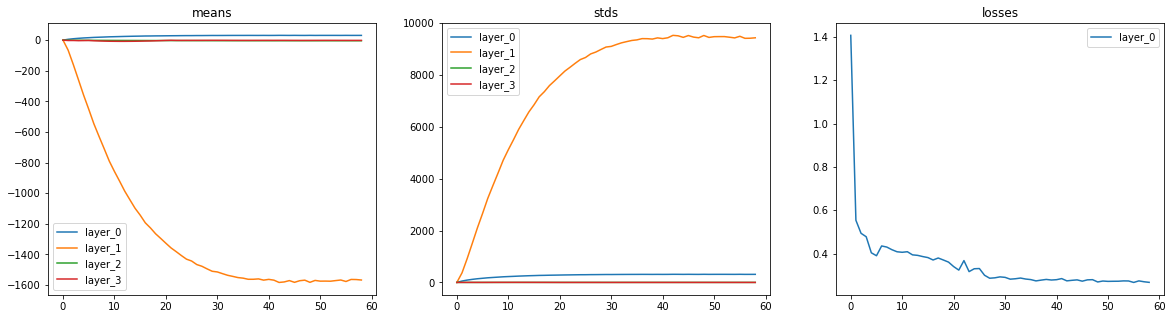

In [84]:
actstats.plot(figsize=(20, 5))